In [1]:
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import my_wise_utility_v2 as my_wise_ut
import astropy.io.fits as pf
import warnings
from astropy.table import Table, vstack
from desi_retriever.blanc import get_specs
import scipy.ndimage as sn
warnings.filterwarnings('ignore')

In [2]:
def deltachi2_limit_maximize(catalog,log_deltach2_bin,total_good_number):
    
    fraction = []
    good_catalog,bad_catalog,bad_1,bad_2 = good_robust_redrock_redshift(catalog)
    good_fraction = []
    for i in range(0,len(log_deltach2_bin['average_bin'])):
        search = np.where(np.log10(catalog['DELTACHI2_cas'])>=log_deltach2_bin['bin'][i])
        good_catalog,bad_catalog,bad_1,bad_2 = good_robust_redrock_redshift(catalog[search[0]])
        
        fraction.append(len(good_catalog)*1.0/len(search[0]))
        good_fraction.append(len(good_catalog)*1.0/total_good_number)
    return log_deltach2_bin['bin'][0:-1],fraction,good_fraction

In [3]:
def sub_sample_based_on_depth(data,depth_min, depth_max):
    return data[(data['R_DEPTH_EBVAIR']>=depth_min) & (data['R_DEPTH_EBVAIR']<depth_max)]

In [974]:
def good_robust_redrock_redshift(data):
    dz = abs(data['Z']-data['best_z'])/(1.+data['best_z'])
    search = np.where((dz<=0.0033) & (data['best_quality']>=2.5))# & (data['dz_subset']<0.0033))
    search_bad = np.where((dz>0.0033) | (data['best_quality']<2.5))# | (data['dz_subset']>0.0033))
    search_bad_1 = np.where((dz>0.0033) & (data['best_quality']>=2.5))
    search_bad_2 = np.where((dz<0.0033) & (data['best_quality']<2.5))
    return data[search[0]],data[search_bad[0]],data[search_bad_1[0]],data[search_bad_2[0]]

In [5]:
def flux_to_mag(catalog):
    g = -2.5*np.log10(catalog['FIBERFLUX_G'])+22.5-3.214*catalog['EBV']
    r = -2.5*np.log10(catalog['FIBERFLUX_R'])+22.5-2.165*catalog['EBV']
    z = -2.5*np.log10(catalog['FIBERFLUX_Z'])+22.5-1.211*catalog['EBV']
    gr_color = g-r
    rz_color = r-z
    coii = gr_color + 1.2*rz_color
    return {'g':g,'r':r,'z':z,'gr':gr_color,'rz':rz_color,'coii':coii}

In [6]:
def calculate_rate(SV_depth_catalog,SV_depth_catalog_cut):
    Total_number = len(SV_depth_catalog)
    good_catalog,bad_catalog,bad_1,bad_2 = good_robust_redrock_redshift(SV_depth_catalog)
    Total_good_number = len(good_catalog)

    Total_cut_number = len(SV_depth_catalog_cut)
    good_catalog,bad_catalog,bad_1,bad_2 = good_robust_redrock_redshift(SV_depth_catalog_cut)

    Redshift_success_rate = len(good_catalog)*1.0/Total_cut_number
    Good_data_completeness = len(good_catalog)*1.0/Total_good_number

    print('Redshift success rate:', Redshift_success_rate)
    print('Good data completeness:', Good_data_completeness)
    print('Combined value:',Redshift_success_rate*Good_data_completeness)
    return Redshift_success_rate,Good_data_completeness
    #print('Bad_1 to total Bad fraction:'. len(bad_1)/len())

In [7]:
def plot_fraction_good(good_catalog, SV_depth_catalog,log_delta_bin):
    x_all = np.log10(SV_depth_catalog['DELTACHI2_cas'])
    x_good = np.log10(good_catalog['DELTACHI2_cas'])
    total_good = len(x_good)
    all_number = []
    good_number = []
    for i_bin in range(0,len(log_delta_bin['average_bin'])):
        search = np.where((x_all>=log_delta_bin['bin'][i_bin]) & (x_all<log_delta_bin['bin'][i_bin+1]))
        all_number.append(len(search[0]))

        search = np.where((x_good>=log_delta_bin['bin'][i_bin]) & (x_good<log_delta_bin['bin'][i_bin+1]))
        good_number.append(len(search[0]))

    print(all_number)
    print(good_number)

    plt.axhline(0.985,ls='--')
    plt.plot(log_delta_bin['average_bin'],np.array(good_number)*1.0/all_number)
    for i_bin in range(0,len(log_delta_bin['average_bin'])):
        plt.text(log_delta_bin['average_bin'][i_bin],(np.array(good_number)*1.0/all_number)[i_bin]-0.08,str(all_number[i_bin]))
        plt.text(log_delta_bin['average_bin'][i_bin],(np.array(good_number)*1.0/all_number)[i_bin]-0.04,str(good_number[i_bin]))

    plt.ylim(-0.1,1.1)
    plt.xlim(0.5,3.1)

In [8]:
def plot_ELG_cc_plot(catalog):
    mag_info = flux_to_mag(catalog)
    
    plt.subplot(2,2,1)
    plt.scatter(mag_info['rz'],mag_info['gr'],s=1)
    plt.xlim(-2,2)
    plt.ylim(-1.5,1)
    plt.xlabel('r-z')
    plt.ylabel('g-r')
    
    plt.subplot(2,2,2)
    plt.scatter(mag_info['z'],mag_info['gr'],s=1)
    plt.xlim(19,24.5)
    plt.ylim(-1.5,1)
    plt.xlabel('z')
    plt.ylabel('gr')
    
    plt.subplot(2,2,3)
    plt.scatter(mag_info['z'],mag_info['rz'],s=1)
    plt.xlabel('z')
    plt.ylabel('r-z')
    plt.xlim(19,24.5)
    plt.ylim(-1.5,2)
    
    plt.subplot(2,2,4)
    plt.scatter(mag_info['z'],mag_info['coii'],s=1)
    plt.xlabel('z')
    plt.ylabel('coii')
    plt.xlim(19,24.5)
    plt.ylim(-1.5,3)

In [1159]:
#dataname = 'ELG_80610_Cascades_subsamples_v2.fits'
#dataname ='ELG_80606_80608_80610_OII.fits'
dataname = 'ELG_80606_80608_80610_OII_SV_3.1_match_with_extra_best_fit.fits'
#dataname ='ELG_80606_80608_80610_subset_merge.fits'
#dataname2 = 'sv1-elg-cascades-3.1_subset_1_2.fits'
dir = '/Users/tlan/Dropbox/Astro_Research/Projects_plots_notes/2020_DESI_visual_inspect/SV1/Cascades_subsamples/'
SV_depth_catalog = pf.getdata(dir+dataname,1)


#dir = '/Users/tlan/Dropbox/Astro_Research/Projects_plots_notes/2020_DESI_visual_inspect/SV1/Cascades_subsamples/'
#SV_depth_catalog2 = pf.getdata(dir+dataname2,1)

#SV_depth_catalog = SV_depth_catalog[((SV_depth_catalog['Z']>1) & (SV_depth_catalog['Z']<1.55))]# & (SV_depth_catalog['SPECTYPE']=="b'GALAXY'")]
SV_depth_catalog = SV_depth_catalog[(SV_depth_catalog['Z']>1.501) & (SV_depth_catalog['Z']<1.57)]# & (SV_depth_catalog['zwarn_cas']<=4)]

#SV_depth_catalog = SV_depth_catalog[((SV_depth_catalog['Z']>1) & (SV_depth_catalog['Z']<1.497) & (SV_depth_catalog['zwarn_cas']==0)) | ((SV_depth_catalog['Z']>1.502) & (SV_depth_catalog['Z']<1.55))]# & (SV_depth_catalog['zwarn_cas']==0))]# & (SV_depth_catalog['SPECTYPE']=="b'GALAXY'")]
#SV_depth_catalog = SV_depth_catalog[((SV_depth_catalog['Z']>1) & (SV_depth_catalog['Z']<1.4))]# & (SV_depth_catalog['zwarn_cas']==0))]
#SV_depth_catalog = SV_depth_catalog[((SV_depth_catalog['Z']>1.4) & (SV_depth_catalog['Z']<1.497)) | ((SV_depth_catalog['Z']>1.502) & (SV_depth_catalog['Z']<1.55))]# | ((SV_depth_catalog['Z']>1.502) & (SV_depth_catalog['Z']<1.55))]# & (SV_depth_catalog['SPECTYPE']=="b'GALAXY'")]
#SV_depth_catalog = SV_depth_catalog[((SV_depth_catalog['Z']>1.4) & (SV_depth_catalog['Z']<1.55))]# | ((SV_depth_catalog['Z']>1.502) & (SV_depth_catalog['Z']<1.55))]# | ((SV_depth_catalog['Z']>1.502) & (SV_depth_catalog['Z']<1.55))]# & (SV_depth_catalog['SPECTYPE']=="b'GALAXY'")]

SV_depth_catalog_cut = SV_depth_catalog#[(SV_depth_catalog['DELTACHI2_cas']>20) & (SV_depth_catalog['Z']<1.3)]
print('No cut at all')
calculate_rate(SV_depth_catalog,SV_depth_catalog_cut)

print('--------')
SV_depth_catalog_cut = SV_depth_catalog[(SV_depth_catalog['DELTACHI2_cas']>20)]# & (SV_depth_catalog['Z']<1.3)]
print('DELTACHI2_cas>20')
calculate_rate(SV_depth_catalog,SV_depth_catalog_cut)

print('--------')
SV_depth_catalog_cut = SV_depth_catalog[((-0.25*(SV_depth_catalog['FOII']/SV_depth_catalog['FOII_ERR'])+4)<np.log10(SV_depth_catalog['DELTACHI2_cas']+SV_depth_catalog['DELTACHI2_1']+SV_depth_catalog['DELTACHI2_2'])) & (SV_depth_catalog['FOII']/SV_depth_catalog['FOII_ERR']>2.5) & (SV_depth_catalog['FOII']>0)]# & (SV_depth_catalog['zwarn_cas']<=4)]# & (SV_depth_catalog['Z']<1.3)]
print('slope')
print(len(SV_depth_catalog_cut))
good_catalog,bad_catalog,bad_1,bad_2=good_robust_redrock_redshift(SV_depth_catalog_cut)
calculate_rate(SV_depth_catalog,SV_depth_catalog_cut)
print('--------')
SV_depth_catalog_cut = SV_depth_catalog[((np.log10(SV_depth_catalog['FOII']/SV_depth_catalog['FOII_ERR']))>0.9-0.2*np.log10(SV_depth_catalog['DELTACHI2_cas']+SV_depth_catalog['DELTACHI2_1']))  & (SV_depth_catalog['FOII']>0)]# & (SV_depth_catalog['zwarn_cas']<=4)]# & (SV_depth_catalog['Z']<1.3)]
print('Anand slope')
print(len(SV_depth_catalog_cut))
good_catalog,bad_catalog,bad_1,bad_2=good_robust_redrock_redshift(SV_depth_catalog_cut)
calculate_rate(SV_depth_catalog,SV_depth_catalog_cut)

print('--------')
SV_depth_catalog_cut = SV_depth_catalog[(SV_depth_catalog['DELTACHI2_cas']>28)]# & (SV_depth_catalog['Z']<1.65)]
print('DELTACHI2_cas>28')
calculate_rate(SV_depth_catalog,SV_depth_catalog_cut)

print('--------')
SV_depth_catalog_cut = SV_depth_catalog[(SV_depth_catalog['DELTACHI2_cas']+SV_depth_catalog['DELTACHI2_1']>100)]# & (SV_depth_catalog['Z']<1.62)]
print('DELTACHI2_cas>100')# & Redrock_z<1.4')
calculate_rate(SV_depth_catalog,SV_depth_catalog_cut)

No cut at all
Redshift success rate: 0.5151883353584447
Good data completeness: 1.0
Combined value: 0.5151883353584447
--------
DELTACHI2_cas>20
Redshift success rate: 0.826879271070615
Good data completeness: 0.8561320754716981
Combined value: 0.7079178665062105
--------
slope
356
Redshift success rate: 0.9382022471910112
Good data completeness: 0.7877358490566038
Combined value: 0.7390555437778249
--------
Anand slope
470
Redshift success rate: 0.874468085106383
Good data completeness: 0.9693396226415094
Combined value: 0.8476565636290646
--------
DELTACHI2_cas>28
Redshift success rate: 0.8553615960099751
Good data completeness: 0.8089622641509434
Combined value: 0.691955253375994
--------
DELTACHI2_cas>100
Redshift success rate: 0.92
Good data completeness: 0.6509433962264151
Combined value: 0.5988679245283018


(0.92, 0.6509433962264151)

In [1128]:
SV_depth_catalog_cut = SV_depth_catalog[((-0.25*(SV_depth_catalog['FOII']/SV_depth_catalog['FOII_ERR'])+2.5)<np.log10(SV_depth_catalog['DELTACHI2_cas'])) & (SV_depth_catalog['FOII']/SV_depth_catalog['FOII_ERR']>2.5) & (SV_depth_catalog['FOII']>0)]# & (SV_depth_catalog['zwarn_cas']<=4)]# & (SV_depth_catalog['Z']<1.3)]
print('slope')
#print(len(SV_depth_catalog_cut))
good_catalog,bad_catalog,bad_1,bad_2=good_robust_redrock_redshift(SV_depth_catalog_cut)
calculate_rate(SV_depth_catalog,SV_depth_catalog_cut)


slope
Redshift success rate: 0.8893905191873589
Good data completeness: 0.9292452830188679
Combined value: 0.8264619447165552


(0.8893905191873589, 0.9292452830188679)

In [11]:
len(SV_depth_catalog_cut)

5904

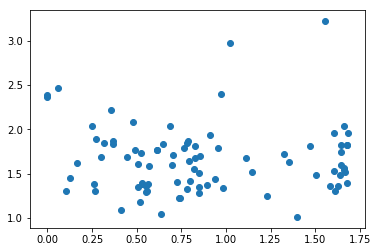

In [12]:
plt.scatter(bad_catalog[bad_catalog['dz_subset']>=0.0033]['Z_2'],np.log10(bad_catalog[bad_catalog['dz_subset']>=0.0033]['DELTACHI2_cas']))

In [12]:
SV_depth_catalog2['TILEID']

array([80605, 80605, 80605, ..., 80610, 80610, 80610])

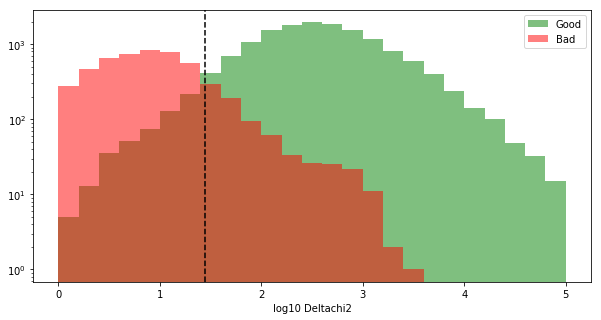

In [13]:
SV_depth_catalog = pf.getdata(dir+dataname,1)
good_catalog,bad_catalog,bad_1,bad_2=good_robust_redrock_redshift(SV_depth_catalog[SV_depth_catalog['zwarn_cas']<=4])
#plt.hist(np.log10(SV_depth_catalog['DELTACHI2_cas']),range=(0,5),bins=20,color='b',alpha=0.3)
plt.figure(figsize=(10,5))
plt.hist(np.log10(good_catalog['DELTACHI2_cas']),range=(0,5),bins=25,alpha=0.5,color='g',label='Good')
plt.hist(np.log10(bad_catalog['DELTACHI2_cas']),range=(0,5),bins=25,alpha=0.5,color='r',label='Bad')
#plt.hist(np.log10(bad_2['DELTACHI2_cas']),range=(0,5),bins=25,alpha=0.5,color='b',label='Bad_1')

plt.axvline(np.log10(28),ls='--',color='black')
plt.legend()
plt.xlabel('log10 Deltachi2')
plt.yscale('log')

(0, 1.8)

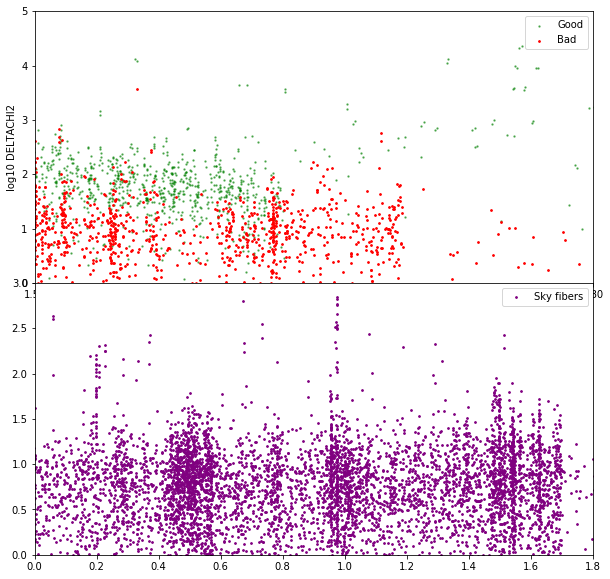

In [18]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.)
plt.subplot(2,1,1)
sky_line = pf.getdata('/Users/tlan/Dropbox/Astro_Research/Projects_plots_notes/2020_DESI_visual_inspect/SV1/sky_line_join.fits',1)
plt.scatter(good_catalog['Z'],np.log10(good_catalog['DELTACHI2_cas']),color='g',s=2,alpha=0.5,label='Good')

plt.scatter(bad_catalog['Z'],np.log10(bad_catalog['DELTACHI2_cas']),color='r',s=3,alpha=1,label='Bad')
#plt.scatter(bad_1['Z'],np.log10(bad_1['DELTACHI2_cas']),color='b',s=3,alpha=1,label='Bad 1')

#plt.scatter(sky_line['Z'][search[0]],np.log10(sky_line['deltachi2'][search[0]]),s=3,color='purple',label='Sky fibers')
#SV_depth_catalog_cut = SV_depth_catalog[((-0.25*(SV_depth_catalog['FOII']/SV_depth_catalog['FOII_ERR'])+2.5)<np.log10(SV_depth_catalog['DELTACHI2_cas'])) & (SV_depth_catalog['FOII']/SV_depth_catalog['FOII_ERR']>2.5) & (SV_depth_catalog['FOII']>0) & (SV_depth_catalog['zwarn_cas']==0)]# & (SV_depth_catalog['zwarn_cas']<=4)]# & (SV_depth_catalog['Z']<1.3)]
#plt.scatter(SV_depth_catalog_cut['Z'],np.log10(SV_depth_catalog_cut['DELTACHI2_cas']),s=5,color='black',alpha=0.3,zorder=0)
plt.legend()
plt.xlim(1.5,1.8)
#plt.axvline(1.497)
#plt.axvline(1.501)
#plt.axvline(1.625)
plt.ylim(0,5)
#plt.axhline(np.log10(100))
plt.xlabel('Redshift')
plt.ylabel('log10 DELTACHI2')

plt.subplot(2,1,2)
search = np.where((sky_line['zwarn']<=4))
plt.scatter(sky_line['Z'][search[0]],np.log10(sky_line['deltachi2'][search[0]]),s=3,color='purple',label='Sky fibers')
plt.ylim(0,3)
plt.legend()
plt.xlim(0,1.8)

Text(0.5, 1.0, 'ELG 80606 & 80608 & 80610')

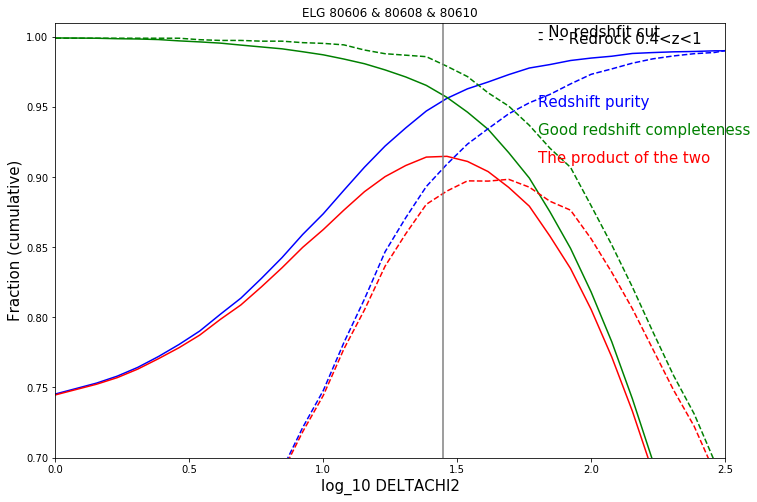

In [12]:
SV_depth_catalog = pf.getdata(dir+dataname,1)
good_catalog,bad_catalog,bad_1,bad_2=good_robust_redrock_redshift(SV_depth_catalog)
total_good_number = len(good_catalog)

log_deltach2_bin = my_wise_ut.my_bin_maker(0.0,3,40)
plt.figure(figsize=(12,8))
bins, fraction,good_fraction = deltachi2_limit_maximize(SV_depth_catalog,log_deltach2_bin,total_good_number)
plt.subplot(1,1,1)
plt.plot(bins,fraction,color='b')
plt.plot(bins,good_fraction,color='g')
plt.plot(bins,np.array(good_fraction)*fraction,color='r')
plt.ylim(0.7,1.01)
plt.xlim(0.0,2.5)
#plt.axhline(0.98,ls='--')

SV_depth_catalog = pf.getdata(dir+dataname,1)
SV_depth_catalog = SV_depth_catalog[(SV_depth_catalog['Z']<0.6) & (SV_depth_catalog['Z']>0.0)]

good_catalog,bad_catalog,bad_1,bad_2=good_robust_redrock_redshift(SV_depth_catalog)
total_good_number = len(good_catalog)


bins, fraction,good_fraction = deltachi2_limit_maximize(SV_depth_catalog,log_deltach2_bin,total_good_number)
plt.plot(bins,fraction,color='b',ls='--')
plt.plot(bins,good_fraction,color='g',ls='--')
plt.plot(bins,np.array(good_fraction)*fraction,color='r',ls='--')

plt.text(1.8,1.0,'- No redshfit cut',fontsize=15,color='black')
plt.text(1.8,0.995,'- - - Redrock 0.4<z<1',fontsize=15,color='black')
plt.text(1.8,0.95,'Redshift purity',fontsize=15,color='b')
plt.text(1.8,0.93,'Good redshift completeness',fontsize=15,color='g')
plt.text(1.8,0.91,'The product of the two',fontsize=15,color='r')
plt.xlabel('log_10 DELTACHI2',fontsize=15)
plt.axvline(np.log10(28),color='grey')
plt.ylabel('Fraction (cumulative)',fontsize=15)
plt.title('ELG 80606 & 80608 & 80610')

In [14]:
SV_depth_catalog = pf.getdata(dir+dataname,1)
SV_depth_catalog
len(SV_depth_catalog[(SV_depth_catalog['best_quality']<2.5) & (SV_depth_catalog['subset_id']==1)])


765

Text(0.5, 0, 'FIBERID')

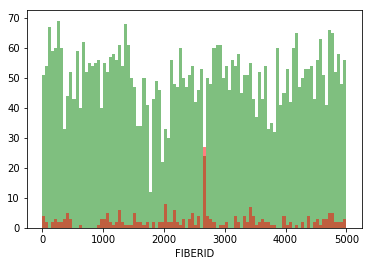

In [15]:
plt.hist(good_catalog['FIBER'][good_catalog['DELTACHI2_cas']>28],range=(-1,5000),bins=100,alpha=0.5,color='g')
plt.hist(bad_catalog['FIBER'][bad_catalog['DELTACHI2_cas']>28],range=(-1,5000),bins=100,alpha=0.5,color='r')
plt.xlabel('FIBERID')

5660
20630


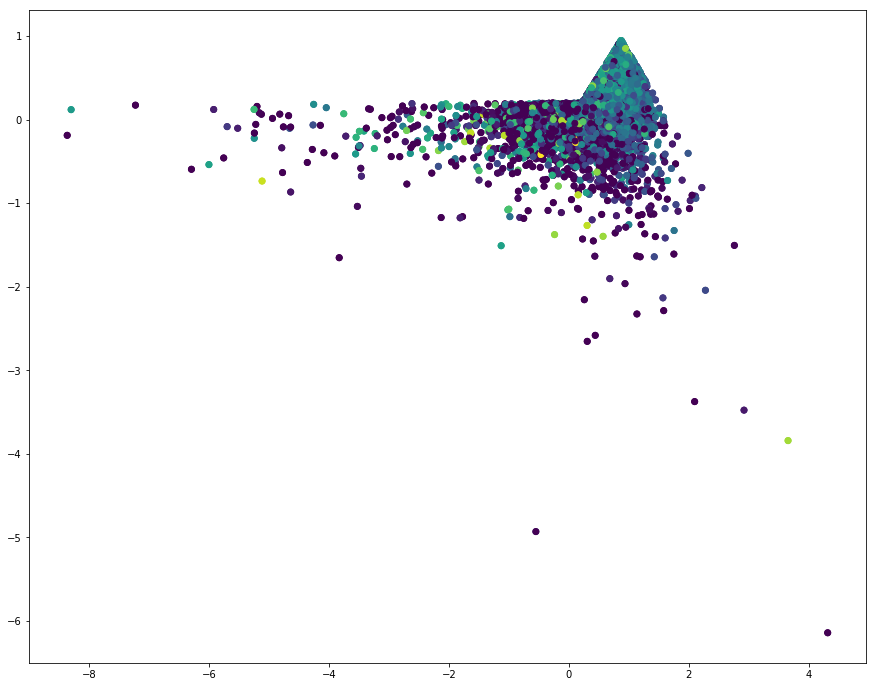

In [69]:
SV_depth_catalog = pf.getdata(dir+dataname,1)
SV_depth_catalog = SV_depth_catalog#[SV_depth_catalog['subset_id']==1]
good_catalog,bad_catalog,bad_1,bad_2=good_robust_redrock_redshift(SV_depth_catalog)
print(len(bad_catalog))
print(len(SV_depth_catalog))
plt.figure(figsize=(15,12))
plt.scatter(flux_to_mag(SV_depth_catalog)['rz'],flux_to_mag(SV_depth_catalog)['gr'],c=np.log10(SV_depth_catalog['DELTACHI2_cas']),vmin=1,vmax=5)
#plot_ELG_cc_plot(good_catalog)
#plot_ELG_cc_plot(bad_catalog)

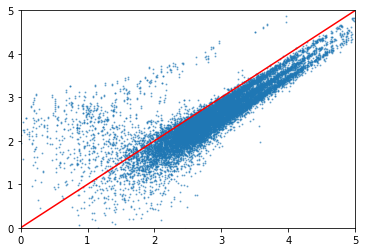

In [70]:
plt.scatter(np.log10(good_catalog['DELTACHI2']),np.log10(good_catalog['DELTACHI2_cas']),s=1,alpha=0.5)
plt.xlim(0,5)
plt.ylim(0,5)
plt.plot(np.arange(0,10),np.arange(0,10),color='r')

In [71]:
SV_depth_catalog['zwarn'][np.where(np.log10(SV_depth_catalog['DELTACHI2_cas'])-np.log10(SV_depth_catalog['DELTACHI2'])>2)]

array([4, 0, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 0, 4, 0, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int16)

Text(0, 0.5, 'log10 DELTACHI2')

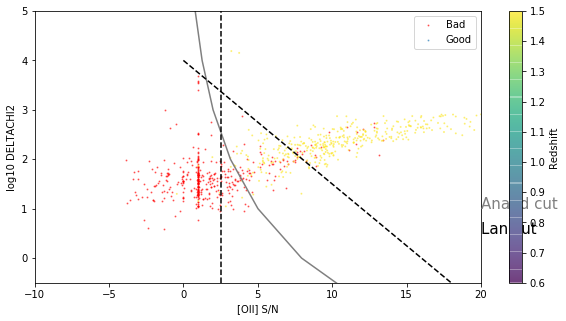

In [1157]:
dataname ='ELG_80606_80608_80610_OII.fits'
dataname = 'ELG_80606_80608_80610_OII_SV_3.1_match_with_extra_best_fit.fits'

SV_depth_catalog = pf.getdata(dir+dataname,1)
#dataname ='ELG_80606_80608_80610_subset_merge.fits'

SV_depth_catalog = SV_depth_catalog[(SV_depth_catalog['Z']>1.501) & (SV_depth_catalog['Z']<1.57)]
#SV_depth_catalog = SV_depth_catalog[((SV_depth_catalog['Z']>1) & (SV_depth_catalog['Z']<1.497)) | ((SV_depth_catalog['Z']>1.502) & (SV_depth_catalog['Z']<1.55))]# & (SV_depth_catalog['SPECTYPE']=="b'GALAXY'")]
#SV_depth_catalog = SV_depth_catalog[((SV_depth_catalog['Z']>1.4) & (SV_depth_catalog['Z']<1.497)) | ((SV_depth_catalog['Z']>1.502) & (SV_depth_catalog['Z']<1.55))]# | ((SV_depth_catalog['Z']>1.502) & (SV_depth_catalog['Z']<1.55))]# & (SV_depth_catalog['SPECTYPE']=="b'GALAXY'")]
SV_depth_catalog_cut = SV_depth_catalog[((-0.25*(SV_depth_catalog['FOII']/SV_depth_catalog['FOII_ERR'])+2.5)<np.log10(SV_depth_catalog['DELTACHI2_cas']+SV_depth_catalog['DELTACHI2_1']+SV_depth_catalog['DELTACHI2_2'])) & (SV_depth_catalog['FOII']/SV_depth_catalog['FOII_ERR']>2.5) & (SV_depth_catalog['FOII']>0)]# & (SV_depth_catalog['zwarn_cas']<=4)]# & (SV_depth_catalog['Z']<1.3)]

good_catalog,bad_catalog,bad_1,bad_2=good_robust_redrock_redshift(SV_depth_catalog)
#print(len(good_catalog))
#print(len(bad_catalog))
plt.figure(figsize=(10,5))
plt.scatter(bad_catalog['FOII']/bad_catalog['FOII_ERR'],np.log10(bad_catalog['DELTACHI2_cas']+bad_catalog['DELTACHI2_1']+bad_catalog['DELTACHI2_2']),color='r',s=1,alpha=0.5,label='Bad')
#plt.scatter(bad_1['FOII']/bad_1['FOII_ERR'],np.log10(bad_1['DELTACHI2_cas']),color='b',s=1,alpha=0.5,label='Bad_1')

plt.scatter(good_catalog['FOII']/good_catalog['FOII_ERR'],np.log10(good_catalog['DELTACHI2_cas']+good_catalog['DELTACHI2_1']+good_catalog['DELTACHI2_2']),c=good_catalog['Z'],s=1,vmax=1.5,vmin=0.6,alpha=0.5,label='Good')
plt.colorbar(label='Redshift')
#plt.scatter(bad_1['Z'],np.log10(bad_1['DELTACHI2_cas']),color='b',s=3,alpha=1,label='Bad 1')

plt.legend()
#plt.xlim(-10,20)
plt.ylim(0,5)
y = np.arange(-5,50)
x = 10**(0.9-0.2*y)
plt.plot(x,y,ls='-',color='grey')
x = np.arange(0,20)
y = -0.25*x+4
plt.plot(x,y,ls='--',color='black')
plt.axvline(2.5,ls='--',color='black')
plt.xlim(-10,20)
plt.ylim(-0.5,5)
#plt.axhline(np.log10(20))
plt.text(20,1,'Anand cut',fontsize=15,color='grey')
plt.text(20,0.5,'Lan cut',fontsize=15,color='black')
plt.xlabel('[OII] S/N')
plt.ylabel('log10 DELTACHI2')

['unusually narrow CIV line Lyman alpha emitter' 'Sky lines' '' '' '' ''
 '' 'weak resolved doublet built from/on one strong skyline residual'
 'unphysical flux increase at Z-band end + no doublet + absorption at 7180AA (MgII ?)  looks robust rising flux at red end probably not real(?) but fit as Balmer break'
 'weak doublet built from/on skyline residuals' 'residuals in Z'
 'redrock missed clear doublet probably due to sky residuals' '' '' '' ''
 'noisy O II'
 'absorption and noise around O II and degeneracy between 2 best models'
 '' 'bad splicing and O II not conclusive' '' 'sky lines' '' '' '' ''
 'Broad [OII] on sky lines strong doublet plagged by noise spike on one line'
 'Sky lines weak doublet built from/on noise spikes' ''
 'doublet from/on skyline residuals is higly dubious Sky lines' '' ''
 'very likely LAE at z=2.292'
 'dubious resolved doublet over/from two strong skyline residuals On the edge around sky lines / could be real but not sure'
 '' 'bad B/R splicing'
 'weak res

(array([ 0.,  3., 18.,  0.,  2.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5]),
 <a list of 5 Patch objects>)

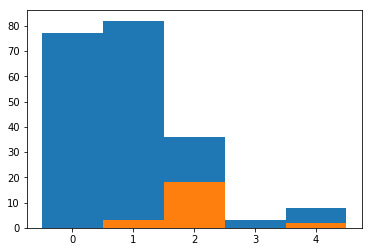

In [180]:
SV_depth_catalog = pf.getdata(dir+dataname,1)
SV_depth_catalog = SV_depth_catalog[(SV_depth_catalog['Z']<1.575) & (SV_depth_catalog['Z']>1.502) & (SV_depth_catalog['subset_id']==1)]
good_catalog,bad_catalog,bad_1,bad_2=good_robust_redrock_redshift(SV_depth_catalog)
plt.hist(bad_catalog['best_quality'],bins=5,range=(-0.5,4.5))
print(bad_catalog['all_VI_comments'])

SV_depth_catalog_cut = SV_depth_catalog[((-0.25*(SV_depth_catalog['FOII']/SV_depth_catalog['FOII_ERR'])+2.5)<np.log10(SV_depth_catalog['DELTACHI2_cas'])) & (SV_depth_catalog['FOII']/SV_depth_catalog['FOII_ERR']>2.5) & (SV_depth_catalog['FOII']>0)]# & (SV_depth_catalog['zwarn_cas']<=4)]# & (SV_depth_catalog['Z']<1.3)]
good_catalog,bad_catalog,bad_1,bad_2=good_robust_redrock_redshift(SV_depth_catalog_cut)
plt.hist(bad_catalog['best_quality'],bins=5,range=(-0.5,4.5))


%matplotlib notebook

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d    

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
x = good_catalog['Z']
y = good_catalog['FOII']/good_catalog['FOII_ERR']
z = np.log10(good_catalog['DELTACHI2_cas'])

ax.scatter(x, y, z, c=good_catalog['Z'],s=1,alpha=0.5)


x = bad_catalog['Z']
y = bad_catalog['FOII']/bad_catalog['FOII_ERR']
z = np.log10(bad_catalog['DELTACHI2_cas'])

ax.scatter(x, y, z, c='r',s=1,alpha=0.5)

ax.set_xlabel('Redshift')
ax.set_ylabel('[OII] S/N')
ax.set_zlabel('log10 Deltachi2')

plt.show()

In [184]:
SV_depth_catalog = pf.getdata(dir+dataname,1)
SV_depth_catalog = SV_depth_catalog[(SV_depth_catalog['subset_id']==1) & (SV_depth_catalog['zwarn_cas']==0)]

In [185]:
def selection_fraction(all_catalog):
    redrock_z = all_catalog['Z']
    OII_SN = all_catalog['FOII']/all_catalog['FOII_ERR']
    log10_deltha2 = np.log10(all_catalog['DELTACHI2_cas'])
    FOII = all_catalog['FOII']
    search_low_z = np.where((redrock_z>0.6)& (redrock_z<1.0) & ((-0.25*OII_SN+2.5)<log10_deltha2) & (OII_SN>2.5) & (FOII>0))
    search_low_z_all = np.where((redrock_z>0.6)& (redrock_z<1.0))
    search_high_z = np.where(((redrock_z>1.0)& (redrock_z<1.497) & ((-0.25*OII_SN+2.5)<log10_deltha2) & (OII_SN>2.5) & (FOII>0)) | ((redrock_z>1.502)& (redrock_z<1.55) & ((-0.25*OII_SN+2.5)<log10_deltha2) & (OII_SN>2.5) & (FOII>0)))
    search_high_z_all = np.where(((redrock_z>1.0)& (redrock_z<1.497)) | ((redrock_z>1.502)& (redrock_z<1.55)))
    
    search_very_low_all = np.where(redrock_z<0.4)
    search_very_low = np.where((redrock_z<0.4) & (log10_deltha2>2))

    search_very_high_all = np.where((redrock_z>1.502) & (redrock_z<1.62))
    search_problem_all = np.where((redrock_z<1.502) & (redrock_z>1.497))
    print('Total N:',len(all_catalog))
    print('low z all:',len(search_low_z_all[0]))
    print('low z selection:',len(search_low_z[0]))
    print('high z all:',len(search_high_z_all[0]))
    print('high z selection:',len(search_high_z[0]))
    print('Very low z all:',len(search_very_low_all[0]))
    print('Very low z selection:',len(search_very_low[0])) 
    print('Very high z all:',len(search_very_high_all[0])) 
    print('Problem z all:',len(search_problem_all[0])) 

In [186]:
selection_fraction(SV_depth_catalog)

Total N: 8516
low z all: 3421
low z selection: 3161
high z all: 3149
high z selection: 2897
Very low z all: 1002
Very low z selection: 756
Very high z all: 470
Problem z all: 95


In [242]:
selection_fraction(SV_depth_catalog)

Total N: 8516
low z all: 3725
low z selection: 3281
high z all: 3149
high z selection: 2897
Very low z all: 1002
Very low z selection: 756
Very high z all: 545
Problem z all: 95


In [211]:
SV_depth_catalog = pf.getdata(dir+dataname,1)
SV_depth_catalog = SV_depth_catalog[(SV_depth_catalog['Z']>1.497) & (SV_depth_catalog['Z']<1.501)]
good_catalog,bad_catalog,bad_1,bad_2=good_robust_redrock_redshift(SV_depth_catalog)


In [212]:
print(len(SV_depth_catalog))
print(len(bad_catalog))
print(len(good_catalog))

223
207
16


In [255]:
SV_depth_catalog_cut = SV_depth_catalog[((-0.25*(SV_depth_catalog['FOII']/SV_depth_catalog['FOII_ERR'])+2.5)<np.log10(SV_depth_catalog['DELTACHI2_cas'])) & (SV_depth_catalog['FOII']/SV_depth_catalog['FOII_ERR']>2.5) & (SV_depth_catalog['FOII']>0)]# & (SV_depth_catalog['Z']<1.3)]
good_catalog,bad_catalog,bad_1,bad_2=good_robust_redrock_redshift(SV_depth_catalog_cut)

In [258]:
print(len(SV_depth_catalog_cut))
print(len(bad_catalog))
print(len(good_catalog))

104
88
16


In [269]:
#dataname = 'ELG_80610_Cascades_subsamples_v2.fits'
dataname ='ELG_80606_80608_80610_OII.fits'

dir = '/Users/tlan/Dropbox/Astro_Research/Projects_plots_notes/2020_DESI_visual_inspect/SV1/Cascades_subsamples/'
redshift_bin = my_wise_ut.my_bin_maker(1.45,1.497,2)
#redshift_bin['bin'][-1]=1.4975
redshift_purity = []
good_data_completeness = []
for i_bin in range(0,len(redshift_bin['average_bin'])):
    SV_depth_catalog = pf.getdata(dir+dataname,1)
    SV_depth_catalog = SV_depth_catalog[(SV_depth_catalog['Z']>=redshift_bin['bin'][i_bin]) & (SV_depth_catalog['Z']<redshift_bin['bin'][i_bin+1])]

    print('--------')
    SV_depth_catalog_cut = SV_depth_catalog[((-0.25*(SV_depth_catalog['FOII']/SV_depth_catalog['FOII_ERR'])+2.5)<np.log10(SV_depth_catalog['DELTACHI2_cas'])) & (SV_depth_catalog['FOII']/SV_depth_catalog['FOII_ERR']>2.5) & (SV_depth_catalog['FOII']>0)]# & (SV_depth_catalog['zwarn_cas']<=4)]# & (SV_depth_catalog['Z']<1.3)]
    print('slope')
    out1,out2 = calculate_rate(SV_depth_catalog,SV_depth_catalog_cut)
    redshift_purity.append(out1)
    good_data_completeness.append(out2)

--------
slope
Redshift success rate: 0.9825708061002179
Good data completeness: 0.9890350877192983
Combined value: 0.9717970034017506


Text(0.7, 0.975, 'Good redshift completeness')

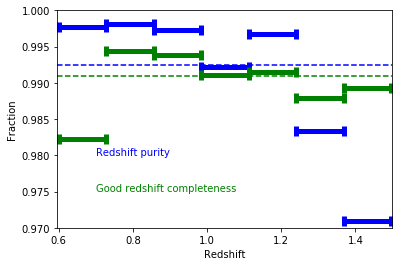

In [256]:
plt.errorbar(redshift_bin['average_bin'],redshift_purity,xerr=[redshift_bin['average_bin']-np.array(redshift_bin['bin'][0:-1]),
                                                              np.array(redshift_bin['bin'])[1:]-1*redshift_bin['average_bin']],ls='',capsize=5,lw=5,mew=5,color='b')




plt.errorbar(redshift_bin['average_bin'],good_data_completeness,xerr=[redshift_bin['average_bin']-np.array(redshift_bin['bin'][0:-1]),
                                                              np.array(redshift_bin['bin'])[1:]-1*redshift_bin['average_bin']],ls='',capsize=5,lw=5,mew=5,color='g')

plt.axhline(0.9925,color='b',ls='--')
plt.axhline(0.991,color='g',ls='--')
plt.ylim(0.97,1)
plt.xlim(0.595,1.4975)
plt.xlabel('Redshift')
plt.ylabel('Fraction')
plt.text(0.7,0.98,'Redshift purity',color='b')
plt.text(0.7,0.975,'Good redshift completeness',color='g')


In [363]:
SV_depth_catalog = pf.getdata(dir+dataname,1)
search = np.where((SV_depth_catalog['Z']>=-1) & (SV_depth_catalog['Z']>1.7) & (SV_depth_catalog['DELTACHI2_cas']>20) & (SV_depth_catalog['DELTACHI2_cas']<200))

In [364]:
print(len(SV_depth_catalog))
len(search[0])

20630


74

In [226]:
search = np.where((SV_depth_catalog['Z']<0.6) & (SV_depth_catalog['Z']>-0.1))
len(search[0])

3868

In [360]:
#SV_depth_catalog = pf.getdata(dir+dataname,1)
#search = np.where((SV_depth_catalog['zwarn_cas']!=0))
good_catalog,bad_catalog,bad_1,bad_2=good_robust_redrock_redshift(SV_depth_catalog)
print(len(good_catalog))
good_catalog,bad_catalog,bad_1,bad_2=good_robust_redrock_redshift(SV_depth_catalog[search[0]])
print(len(good_catalog))
print(len(bad_catalog))

14970
54
20


In [ ]:
# bad_catalog['all_VI_comments']

(0.1, 2)

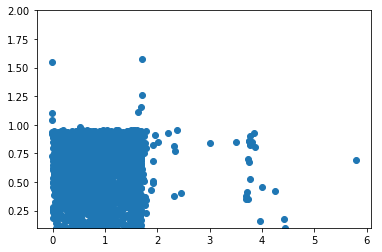

In [86]:
plt.scatter(SV_depth_catalog['Z'][search[0]],np.log10(SV_depth_catalog['DELTACHI2_cas'][search[0]]))
plt.ylim(0.1,2)

In [319]:
SV_depth_catalog = pf.getdata(dir+dataname,1)
search = np.where(((SV_depth_catalog['FOII']/SV_depth_catalog['FOII_ERR'])>5) & (SV_depth_catalog['Z']<0.6) & (SV_depth_catalog['DELTACHI2_cas']>10) & (SV_depth_catalog['DELTACHI2_cas']<150))

In [320]:
SV_depth_catalog['all_VI_comments'][search[0]]

chararray(['Lyman alpha emitter', 'O II in slice but looks robust',
           'Lyman alpha emitter? Strong narrow line could be Lya strong thin line at 4770AA and nothing else : possible Lyman alpha emitter',
           'Stron emission at 4500A does not seem to be OII. Lyman alpha emitter at z=2.7110 ? best fit doublet is a strong spike (cosmic ?) + nothing else',
           '',
           'strong signal unresolved and no other line : possible Lyman alpha emitter',
           'Lyman alpha emitter', 'O II in slice but looks robust',
           'Lyman alpha emitter? Strong narrow line could be Lya strong thin line at 4770AA and nothing else : possible Lyman alpha emitter',
           'strong signal unresolved and no other line : possible Lyman alpha emitter',
           'Lyman alpha emitter at redshift 2.2733 OII feature at <4000A not definitive and no other obvious features',
           'Broad [OII]',
           'clear narrow emission at 4100AA and no broad emissions : QSO ?',
        

In [316]:
len(search[0])

85

In [331]:
np.log10(150)

2.1760912590556813

In [407]:
SV_depth_catalog = pf.getdata(dir+dataname,1)
search = np.where((SV_depth_catalog['Z']<1.62) & (SV_depth_catalog['Z']>1.501) &(SV_depth_catalog['DELTACHI2_cas']>20))
#SV_depth_catalog_cut = SV_depth_catalog[(SV_depth_catalog['Z']>=0.6) & (SV_depth_catalog['Z']<1.497) &((-0.25*(SV_depth_catalog['FOII']/SV_depth_catalog['FOII_ERR'])+2.5)<np.log10(SV_depth_catalog['DELTACHI2_cas'])) & (SV_depth_catalog['FOII']/SV_depth_catalog['FOII_ERR']>2.5) & (SV_depth_catalog['FOII']>0)]# & (SV_depth_catalog['zwarn_cas']<=4)]# & (SV_depth_catalog['Z']<1.3)]
print(len(search[0]))

733


In [408]:
good_catalog,bad_catalog,bad_1,bad_2=good_robust_redrock_redshift(SV_depth_catalog[search[0]])


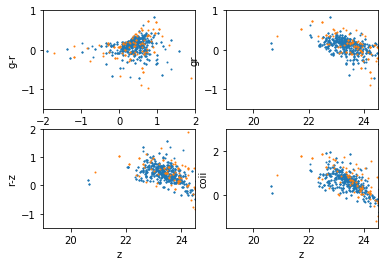

In [412]:

plot_ELG_cc_plot(good_catalog)
plot_ELG_cc_plot(bad_catalog)

In [421]:
bad_catalog['all_VI_comments']

chararray(['Around sky lines two weak', '',
           'unphysical flux increase at Z-band end + no doublet + absorption at 7180AA (MgII ?)  looks robust rising flux at red end probably not real(?) but fit as Balmer break',
           'redrock missed clear doublet probably due to sky residuals',
           'absorption and noise around O II and degeneracy between 2 best models',
           'Broad [OII] on sky lines strong doublet plagged by noise spike on one line',
           '', '', '',
           'Possible broad absorption features but not sure what they are possible resolved doublet plagged by noise spike and close to strong skyline residual',
           'weak doublet built from/on noise spike + dropout of Z continuum',
           '',
           'broad noisy doublet in between skylines [OII] seems real but not crystal clear',
           '', 'very noisy doublet in between skyline residuals',
           'On the sky lines', 'doublet built on a noise spike',
           'resolved doublet

# Exploring two redshifts information 

In [1143]:
dataname = 'ELG_80606_80608_80610_OII_SV_3.1_match_with_extra_best_fit.fits'
dir = '/Users/tlan/Dropbox/Astro_Research/Projects_plots_notes/2020_DESI_visual_inspect/SV1/Cascades_subsamples/'
SV_depth_catalog = pf.getdata(dir+dataname,1)
SV_depth_catalog = SV_depth_catalog[(SV_depth_catalog['Z']>1.501) & (SV_depth_catalog['Z']<1.57)  & (SV_depth_catalog['spectype']=="b'GALAXY'")]
z_1 = SV_depth_catalog['Z_1']
best_z = SV_depth_catalog['Z']

search_z = np.where(
    #(SV_depth_catalog['DELTACHI2_cas']+SV_depth_catalog['DELTACHI2_1']+SV_depth_catalog['DELTACHI2_2']>10) & 
    ((SV_depth_catalog['DELTACHI2_cas']+SV_depth_catalog['DELTACHI2_1']+SV_depth_catalog['DELTACHI2_2']>100) & #(SV_depth_catalog['DELTACHI2_cas']+SV_depth_catalog['DELTACHI2_1']<500) & #(SV_depth_catalog['zwarn_1']==0) & # (SV_depth_catalog['DELTACHI2_cas']+SV_depth_catalog['DELTACHI2_1']>100) &# (SV_depth_catalog['DELTACHI2_1']/SV_depth_catalog['DELTACHI2_cas']>1) & 
    #(SV_depth_catalog['FOII']/SV_depth_catalog['FOII_ERR']>3)  &
    (((z_1>=3710.*(1+best_z)/5007-1) & (z_1<3770.*(1+best_z)/5007-1)) | ((z_1>=3720.*(1+best_z)/6563-1) & (z_1<3740.*(1+best_z)/6563-1)))))

 
search_p = np.where(
    (SV_depth_catalog['DELTACHI2_cas']+SV_depth_catalog['DELTACHI2_1']>0) & #(SV_depth_catalog['DELTACHI2_cas']+SV_depth_catalog['DELTACHI2_1']<500) & #(SV_depth_catalog['zwarn_1']==0) & # (SV_depth_catalog['DELTACHI2_cas']+SV_depth_catalog['DELTACHI2_1']>100) &# (SV_depth_catalog['DELTACHI2_1']/SV_depth_catalog['DELTACHI2_cas']>1) & 
    #(SV_depth_catalog['FOII']>0)  &
    (z_1>1))# ((z_1<3720.*(1+best_z)/6563-1) | (z_1>3740.*(1+best_z)/6563-1))))

        
    
'''    
search_z = np.where(
    (SV_depth_catalog['DELTACHI2_cas']+SV_depth_catalog['DELTACHI2_1']>100) | # (SV_depth_catalog['DELTACHI2_1']/SV_depth_catalog['DELTACHI2_cas']>1) & 
    #((np.log10(SV_depth_catalog['FOII']/SV_depth_catalog['FOII_ERR']))>0.9-0.2*np.log10(SV_depth_catalog['DELTACHI2_cas']))  & (SV_depth_catalog['FOII']>0))# &
    ((SV_depth_catalog['DELTACHI2_cas']+SV_depth_catalog['DELTACHI2_1']<100) & 
     (SV_depth_catalog['DELTACHI2_cas']+SV_depth_catalog['DELTACHI2_1']>20) & 
     (((z_1>=3720.*(1+best_z)/5007-1) & (z_1<3770.*(1+best_z)/5007-1)))) | 
      ((z_1>=3720.*(1+best_z)/6563-1) & (z_1<3740.*(1+best_z)/6563-1)))
'''  
good_catalog_total,bad_catalog_total,bad_1,bad_2 = good_robust_redrock_redshift(SV_depth_catalog)
total_good = len(good_catalog_total)
good_catalog,bad_catalog,bad_1,bad_2=good_robust_redrock_redshift(SV_depth_catalog[search_z[0]])

In [1144]:
#print(SV_depth_catalog)
print(len(best_z))
print(len(search_z[0])/len(best_z)*4)
print(len(good_catalog)/len(search_z[0]))
print(len(good_catalog)/total_good)

801
1.797752808988764
0.95
0.8181818181818182


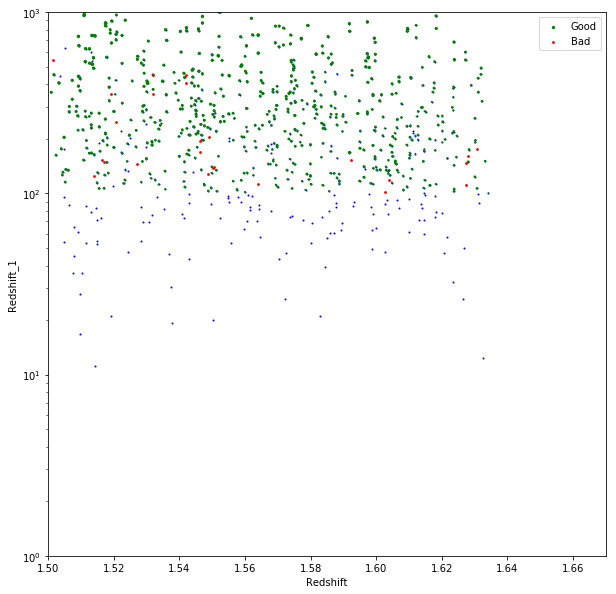

In [1121]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.)
plt.subplot(1,1,1)
plt.scatter(good_catalog_total['Z'],good_catalog_total['DELTACHI2_cas']+good_catalog_total['DELTACHI2_1']+good_catalog_total['DELTACHI2_2'],color='b',s=1)

plt.scatter(good_catalog['Z'],good_catalog['DELTACHI2_cas']+good_catalog['DELTACHI2_1']+good_catalog['DELTACHI2_2'],s=np.log10(good_catalog['DELTACHI2_cas'])**2,color='g',alpha=1,label='Good')

plt.scatter(bad_catalog['Z'],bad_catalog['DELTACHI2_cas']+bad_catalog['DELTACHI2_1']+bad_catalog['DELTACHI2_2'],color='r',s=3,alpha=1,label='Bad')

#plt.scatter(bad_catalog_total['Z'],bad_catalog_total['DELTACHI2_cas']+bad_catalog_total['DELTACHI2_1']+bad_catalog_total['DELTACHI2_2'],color='r',s=3,alpha=1,label='orange')

#plt.scatter(bad_1['Z'],np.log10(bad_1['DELTACHI2_cas']),color='b',s=3,alpha=1,label='Bad 1')
#plt.plot(good_catalog['Z'],3740*(1+good_catalog['Z'])/6563-1)
#plt.scatter(sky_line['Z'][search[0]],np.log10(sky_line['deltachi2'][search[0]]),s=3,color='purple',label='Sky fibers')
#SV_depth_catalog_cut = SV_depth_catalog[((-0.25*(SV_depth_catalog['FOII']/SV_depth_catalog['FOII_ERR'])+2.5)<np.log10(SV_depth_catalog['DELTACHI2_cas'])) & (SV_depth_catalog['FOII']/SV_depth_catalog['FOII_ERR']>2.5) & (SV_depth_catalog['FOII']>0) & (SV_depth_catalog['zwarn_cas']==0)]# & (SV_depth_catalog['zwarn_cas']<=4)]# & (SV_depth_catalog['Z']<1.3)]
#plt.scatter(SV_depth_catalog_cut['Z'],np.log10(SV_depth_catalog_cut['DELTACHI2_cas']),s=5,color='black',alpha=0.3,zorder=0)
plt.legend()
plt.xlim(1.5,1.67)
#plt.axvline(1.497)
#plt.axvline(1.501)
#plt.axvline(1.625)
#plt.scatter(SV_depth_catalog['Z'][search_z[0]],SV_depth_catalog['Z_1'][search_z[0]])
plt.ylim(1,1000)
#plt.axhline(np.log10(100))
plt.xlabel('Redshift')
plt.ylabel('Redshift_1')
plt.yscale('log')
#plt.axvline(1.635)

In [1078]:
SV_depth_catalog['SPECTYPE']

chararray(["b'GALAXY'", "b'GALAXY'", "b'GALAXY'", ..., "b'GALAXY'",
           "b'GALAXY'", "b'GALAXY'"], dtype='<U9')

In [610]:
bad_catalog['all_VI_comments']
#SV_depth_catalog['best_quality']

chararray(['Around sky lines two weak',
           'weak doublet built from/on noise spike + dropout of Z continuum',
           '', 'Sky lines not sure',
           'weak noisy doublet in between two skyline residuals Maybe [OII]',
           'Broad [OII] on sky lines strong doublet plagged by noise spike on one line',
           'very noisy doublet in between skyline residuals',
           'weak resolved doublet highly noisy on one line',
           'noisy resolved doublet close to strong skyline residual',
           'possible doublet sitting on strong skyline residuals so highly distorted and unsecure',
           'negative doublet from strong skyline residuals gives high Dchi2 Between sky lines not sure',
           'probable signal sitting on skyline residual + strong skyline residuals above 9300AA',
           'Strong line at 9400; prob O2; redshift tweaked z_VI better match to noisy doublet which could be pure noise as well + strong skyline residuals',
           'strong skylin

(array([ 1.,  1.,  1.,  0.,  0., 21.,  0.,  0.,  0.,  0.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

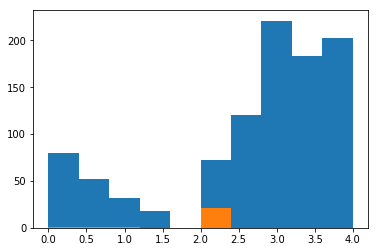

In [565]:
plt.hist(SV_depth_catalog['best_quality'],bins=10,range=(0,4))
plt.hist(bad_catalog['best_quality'],bins=10,range=(0,4))

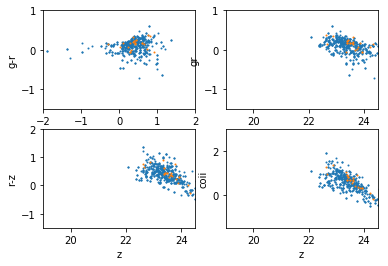

In [571]:
plot_ELG_cc_plot(good_catalog)
plot_ELG_cc_plot(bad_catalog)